# Clase 10:	Inclusión de un activo libre de riesgo en el portafolio

[Juan Diego Sánchez Torres](https://www.researchgate.net/profile/Juan_Diego_Sanchez_Torres), 

*Profesor*, [MAF ITESO](http://maf.iteso.mx/web/general/detalle?group_id=5858156)

+ Departamento de Matemáticas y Física
+ dsanchez@iteso.mx
+ Tel. 3669-34-34 Ext. 3069
+ Oficina: Cubículo 4, Edificio J, 2do piso

# 1. Motivación

En primer lugar, para poder bajar precios y información sobre opciones de Yahoo, es necesario cargar algunos paquetes de Python. En este caso, el paquete principal será Pandas. También, se usarán el Scipy y el Numpy para las matemáticas necesarias y, el Matplotlib y el Seaborn para hacer gráficos de las series de datos.

In [1]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
from datetime import datetime
import scipy.stats as stats
import scipy as sp
import scipy.optimize as scopt
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.covariance as skcov
%matplotlib inline
#algunas opciones para Python
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

# 2. Uso de Pandas para descargar datos de precios de cierre

Bajar datos en forma de función

In [2]:
def get_historical_closes(ticker, start_date, end_date):
    p = web.DataReader(ticker, "yahoo", start_date, end_date).sort_index('major_axis')
    d = p.to_frame()['Adj Close'].reset_index()
    d.rename(columns={'minor': 'Ticker', 'Adj Close': 'Close'}, inplace=True)
    pivoted = d.pivot(index='Date', columns='Ticker')
    pivoted.columns = pivoted.columns.droplevel(0)
    return pivoted

Una vez cargados los paquetes, es necesario definir los tickers de las acciones que se usarán, la fuente de descarga (Yahoo en este caso, pero también se puede desde Google) y las fechas de interés. Con esto, la función *DataReader* del paquete *pandas_datareader* bajará los precios solicitados.

**Nota**: Usualmente, las distribuciones de Python no cuentan, por defecto, con el paquete *pandas_datareader*. Por lo que será necesario instalarlo aparte. El siguiente comando instala el paquete en Anaconda:
*conda install -c conda-forge pandas-datareader *

In [3]:
assets = ['AAPL','AMZN','MSFT','KO']
closes=get_historical_closes(assets, '2010-01-01', '2016-12-31')
closes

Ticker,AAPL,AMZN,KO,MSFT
Date,,,,
2010-01-04,27.505,133.90,22.554,25.275
2010-01-05,27.553,134.69,22.282,25.283
2010-01-06,27.114,132.25,22.274,25.128
2010-01-07,27.064,130.00,22.218,24.867
2010-01-08,27.244,133.52,21.807,25.038
...,...,...,...,...
2016-12-23,115.088,760.59,40.577,62.169
2016-12-27,115.819,771.40,40.586,62.209
2016-12-28,115.325,772.13,40.372,61.924


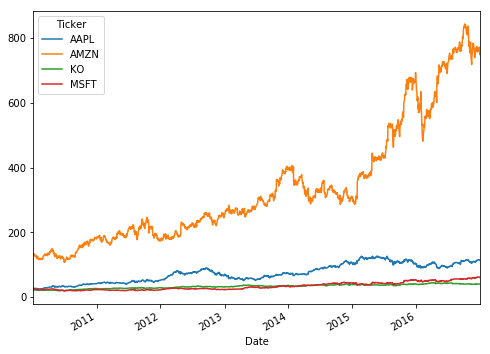

In [4]:
closes.plot(figsize=(8,6));

**Nota**: Para descargar datos de la bolsa mexicana de valores (BMV), el ticker debe tener la extensión MX. 
Por ejemplo: *MEXCHEM.MX*, *LABB.MX*, *GFINBURO.MX* y *GFNORTEO.MX*.

# 3. Formulación del riesgo de un portafolio

In [30]:
def calc_daily_returns(closes):
    return np.log(closes/closes.shift(1))[1:]

In [110]:
daily_returns=calc_daily_returns(closes)
daily_returns

Ticker,AAPL,AMZN,KO,MSFT
Date,,,,
2010-01-05,1.727e-03,5.883e-03,-1.217e-02,3.230e-04
2010-01-06,-1.603e-02,-1.828e-02,-3.551e-04,-6.156e-03
2010-01-07,-1.850e-03,-1.716e-02,-2.488e-03,-1.045e-02
2010-01-08,6.626e-03,2.672e-02,-1.868e-02,6.873e-03
2010-01-11,-8.861e-03,-2.434e-02,2.010e-02,-1.280e-02
...,...,...,...,...
2016-12-23,1.976e-03,-7.531e-03,1.202e-03,-4.890e-03
2016-12-27,6.331e-03,1.411e-02,2.405e-04,6.322e-04
2016-12-28,-4.273e-03,9.459e-04,-5.301e-03,-4.593e-03


In [59]:
daily_returns_b=calc_daily_returns(closes)
yb=0.0001
daily_returns_b['BOND']=yb*np.ones(daily_returns.index.size)
daily_returns_b

Ticker,AAPL,AMZN,KO,MSFT,BOND
Date,,,,,
2010-01-05,1.727e-03,5.883e-03,-1.217e-02,3.230e-04,1.000e-04
2010-01-06,-1.603e-02,-1.828e-02,-3.551e-04,-6.156e-03,1.000e-04
2010-01-07,-1.850e-03,-1.716e-02,-2.488e-03,-1.045e-02,1.000e-04
2010-01-08,6.626e-03,2.672e-02,-1.868e-02,6.873e-03,1.000e-04
2010-01-11,-8.861e-03,-2.434e-02,2.010e-02,-1.280e-02,1.000e-04
...,...,...,...,...,...
2016-12-23,1.976e-03,-7.531e-03,1.202e-03,-4.890e-03,1.000e-04
2016-12-27,6.331e-03,1.411e-02,2.405e-04,6.322e-04,1.000e-04
2016-12-28,-4.273e-03,9.459e-04,-5.301e-03,-4.593e-03,1.000e-04


In [60]:
mean_daily_returns = pd.DataFrame(daily_returns.mean(),columns=['Mean'],index=daily_returns.columns)
mean_daily_returns

,Mean
Ticker,
AAPL,8.094e-04
AMZN,9.783e-04
KO,3.316e-04
MSFT,5.011e-04


In [61]:
mean_daily_returns_b = pd.DataFrame(daily_returns_b.mean(),columns=['Mean'],index=daily_returns_b.columns)
mean_daily_returns_b

,Mean
Ticker,
AAPL,8.094e-04
AMZN,9.783e-04
KO,3.316e-04
MSFT,5.011e-04
BOND,1.000e-04


In [62]:
cov_matrix = daily_returns.cov()
cov_matrix

Ticker,AAPL,AMZN,KO,MSFT
Ticker,,,,
AAPL,2.730e-04,1.104e-04,4.605e-05,9.506e-05
AMZN,1.104e-04,4.131e-04,5.615e-05,1.200e-04
KO,4.605e-05,5.615e-05,9.051e-05,5.659e-05
MSFT,9.506e-05,1.200e-04,5.659e-05,2.126e-04


In [63]:
cov_matrix_b = daily_returns_b.cov()
cov_matrix_b

Ticker,AAPL,AMZN,KO,MSFT,BOND
Ticker,,,,,
AAPL,2.730e-04,1.104e-04,4.605e-05,9.506e-05,-1.389e-39
AMZN,1.104e-04,4.131e-04,5.615e-05,1.200e-04,3.473e-40
KO,4.605e-05,5.615e-05,9.051e-05,5.659e-05,9.484e-40
MSFT,9.506e-05,1.200e-04,5.659e-05,2.126e-04,-2.939e-39
BOND,-1.389e-39,3.473e-40,9.484e-40,-2.939e-39,1.838e-40


In [64]:
#robust_cov_matrix= pd.DataFrame(skcov.EmpiricalCovariance().fit(daily_returns).covariance_,columns=daily_returns.columns,index=daily_returns.columns)
#robust_cov_matrix= pd.DataFrame(skcov.EllipticEnvelope().fit(daily_returns).covariance_,columns=daily_returns.columns,index=daily_returns.columns)
#robust_cov_matrix= pd.DataFrame(skcov.MinCovDet().fit(daily_returns).covariance_,columns=daily_returns.columns,index=daily_returns.columns)
robust_cov_matrix= pd.DataFrame(skcov.ShrunkCovariance().fit(daily_returns).covariance_,columns=daily_returns.columns,index=daily_returns.columns)
robust_cov_matrix

Ticker,AAPL,AMZN,KO,MSFT
Ticker,,,,
AAPL,2.703e-04,9.927e-05,4.142e-05,8.551e-05
AMZN,9.927e-05,3.963e-04,5.051e-05,1.080e-04
KO,4.142e-05,5.051e-05,1.061e-04,5.090e-05
MSFT,8.551e-05,1.080e-04,5.090e-05,2.160e-04


In [65]:
robust_cov_matrix_b= pd.DataFrame(skcov.ShrunkCovariance().fit(daily_returns_b).covariance_,columns=daily_returns_b.columns,index=daily_returns_b.columns)
robust_cov_matrix_b

Ticker,AAPL,AMZN,KO,MSFT,BOND
Ticker,,,,,
AAPL,2.653e-04,9.927e-05,4.142e-05,8.551e-05,-1.250e-39
AMZN,9.927e-05,3.913e-04,5.051e-05,1.080e-04,3.124e-40
KO,4.142e-05,5.051e-05,1.012e-04,5.090e-05,8.531e-40
MSFT,8.551e-05,1.080e-04,5.090e-05,2.110e-04,-2.643e-39
BOND,-1.250e-39,3.124e-40,8.531e-40,-2.643e-39,1.977e-05


# 4. Optimización de portafolios

In [114]:
num_portfolios = 25000
num_assets=len(assets)
r=0.0001
results = np.zeros((3+num_assets,num_portfolios))
for i in range(num_portfolios):
    #Pesos
    weights = np.array(np.random.random(num_assets))
    weights /= np.sum(weights)
 
    #Rendimiento y volatilidad
    portfolio_return = mean_daily_returns.T.dot(weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(robust_cov_matrix, weights))) * np.sqrt(252)
 
    #Resultados
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #Sharpe
    results[2,i] = (results[0,i]-r) / results[1,i]
    
    #Iteraciones
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

In [107]:
r=0.0001
num_assets_b=len(assets)+1
results_b = np.zeros((3+num_assets_b,num_portfolios))
for i in range(num_portfolios):
    #Pesos
    weights_b = np.array(np.random.random(num_assets_b))
    weights_b /= np.sum(weights_b)
 
    #Rendimiento y volatilidad
    portfolio_return_b = mean_daily_returns_b.T.dot(weights) * 252
    portfolio_std_dev_b = np.sqrt(np.dot(weights.T,np.dot(robust_cov_matrix_b, weights))) * np.sqrt(252)
 
    #Resultados
    results_b[0,i] = portfolio_return_b
    results_b[1,i] = portfolio_std_dev_b
    #Sharpe
    results_b[2,i] = (results_b[0,i]-r) / results_b[1,i]
    
    #Iteraciones
    for j in range(len(weights_b)):
        results_b[j+3,i] = weights_b[j]
results_b[3:,0]=np.zeros(num_assets_b)   
results_b[:,0][-1]=1
results_b[:,0][0]=yb
results_b[:,0][1]=0
results_b[:,0][2]=0

In [138]:
results_frame = pd.DataFrame(results.T,columns=(['Rendimiento','SD','Sharpe']+list(daily_returns.columns)))

In [139]:
results_frame_b = pd.DataFrame(results_b.T,columns=(['Rendimiento','SD','Sharpe']+list(daily_returns_b.columns)))

In [140]:
#Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['Sharpe'].idxmax()]
#Menor SD
min_vol_port = results_frame.iloc[results_frame['SD'].idxmin()]

In [141]:
#Sharpe Ratio
max_sharpe_port_b = results_frame_b.iloc[results_frame_b['Sharpe'].idxmax()]
#Menor SD
min_vol_port_b = results_frame_b.iloc[results_frame_b['SD'].idxmin()]

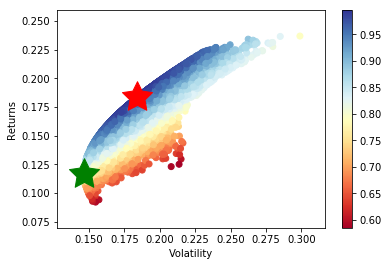

In [142]:
plt.scatter(results_frame.SD,results_frame.Rendimiento,c=results_frame.Sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=1000);
#Menor SD
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=1000);

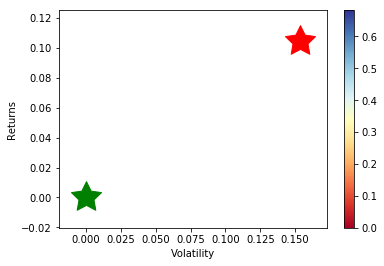

In [143]:
plt.scatter(results_frame_b.SD,results_frame_b.Rendimiento,c=results_frame_b.Sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#Sharpe Ratio
plt.scatter(max_sharpe_port_b[1],max_sharpe_port_b[0],marker=(5,1,0),color='r',s=1000);
#Menor SD
plt.scatter(min_vol_port_b[1],min_vol_port_b[0],marker=(5,1,0),color='g',s=1000);

In [144]:
pd.DataFrame(max_sharpe_port)

,13985
Rendimiento,0.183
SD,0.184
Sharpe,0.996
AAPL,0.385
AMZN,0.314
KO,0.245
MSFT,0.056


In [145]:
pd.DataFrame(max_sharpe_port_b)

,1
Rendimiento,0.105
SD,0.153
Sharpe,0.682
AAPL,0.125
AMZN,0.298
KO,0.109
MSFT,0.235
BOND,0.233


In [146]:
pd.DataFrame(min_vol_port)

,16127
Rendimiento,0.117
SD,0.147
Sharpe,0.798
AAPL,0.145
AMZN,0.048
KO,0.617
MSFT,0.189


In [147]:
pd.DataFrame(min_vol_port_b)

,0
Rendimiento,1.000e-04
SD,0.000e+00
Sharpe,0.000e+00
AAPL,0.000e+00
AMZN,0.000e+00
KO,0.000e+00
MSFT,0.000e+00
BOND,1.000e+00
